In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
# Thiết lập tham số
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data generator
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')
valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/data/train/',
                                                    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
valid_generator = valid_test_datagen.flow_from_directory('/content/drive/MyDrive/data/valid/',
                                                         target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = valid_test_datagen.flow_from_directory('/content/drive/MyDrive/data/test/',
                                                        target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

Found 3780 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.
Found 540 images belonging to 3 classes.


In [ ]:
# Load EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Đóng băng layer ban đầu

# Thêm các layer tùy chỉnh
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)  # 3 class: normal, osteopenia, osteoporosis

# Tạo mô hình
model = Model(inputs=base_model.input, outputs=outputs)

# Xem tóm tắt mô hình
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,213,926 (16.07 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Compile mô hình cho giai đoạn 1 với metric bổ sung
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/foot_model_best_phase1.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Giai đoạn 1: Huấn luyện với base model đóng băng
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=25,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples // BATCH_SIZE,
                    callbacks=callbacks)

Epoch 1/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.3405 - loss: 1.1272 - precision: 0.3780 - recall: 0.0277

118/118 ━━━━━━━━━━━━━━━━━━━━ 98s 635ms/step - accuracy: 0.3405 - loss: 1.1270 - precision: 0.3779 - recall: 0.0276 - val_accuracy: 0.3305 - val_loss: 1.1007 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
  1/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.3125 - loss: 1.0975 - precision: 0.0000e+00 - recall: 0.0000e+00

118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.3125 - loss: 1.0975 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3343 - val_loss: 1.1006 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.3274 - loss: 1.1014 - precision: 0.0000e+00 - recall: 0.0000e+00

118/118 ━━━━━━━━━━━━━━━━━━━━ 82s 694ms/step - accuracy: 0.3275 - loss: 1.1014 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3362 - val_loss: 1.0986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.1875 - loss: 1.1002 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3343 - val_loss: 1.0986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 82s 699ms/step - accuracy: 0.3248 - loss: 1.0987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3343 - val_loss: 1.0986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.2188 - loss: 1.0994 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3314 - val_loss: 1.0986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epo

In [ ]:
# Giai đoạn 2: Fine-tuning
base_model.trainable = True  # Mở khóa base model
for layer in base_model.layers[:-20]:  # Đóng băng trừ 20 layer cuối
    layer.trainable = False

# Compile lại với learning rate nhỏ và metric bổ sung
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Fine-tune mô hình
history_fine = model.fit(train_generator,
                         steps_per_epoch=train_generator.samples // BATCH_SIZE,
                         epochs=20,
                         validation_data=valid_generator,
                         validation_steps=valid_generator.samples // BATCH_SIZE,
                         callbacks=callbacks)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.3362 - loss: 1.1103 - precision: 0.3626 - recall: 0.0117

118/118 ━━━━━━━━━━━━━━━━━━━━ 104s 660ms/step - accuracy: 0.3361 - loss: 1.1102 - precision: 0.3631 - recall: 0.0117 - val_accuracy: 0.3371 - val_loss: 1.0986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.3125 - loss: 1.0838 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3343 - val_loss: 1.0986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 81s 691ms/step - accuracy: 0.3226 - loss: 1.1032 - precision: 0.1401 - recall: 1.2581e-04 - val_accuracy: 0.3267 - val_loss: 1.0986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.3438 - loss: 1.0914 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3352 - val_loss: 1.0986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-0

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 460ms/step - accuracy: 0.3613 - loss: 1.0986 - precision: 0.0000e+00 - recall: 0.0000e+00
Test accuracy: 0.3333, Precision: 0.0000, Recall: 0.0000


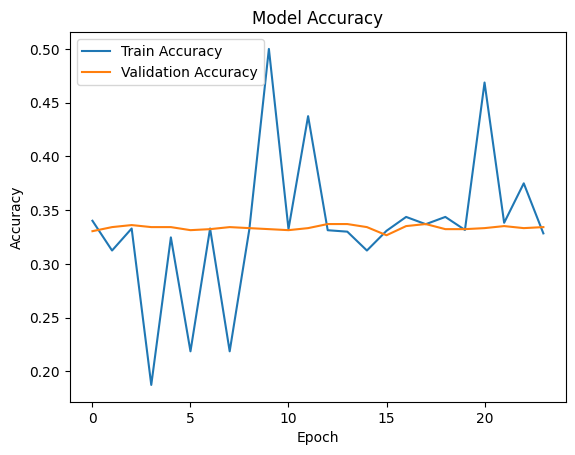

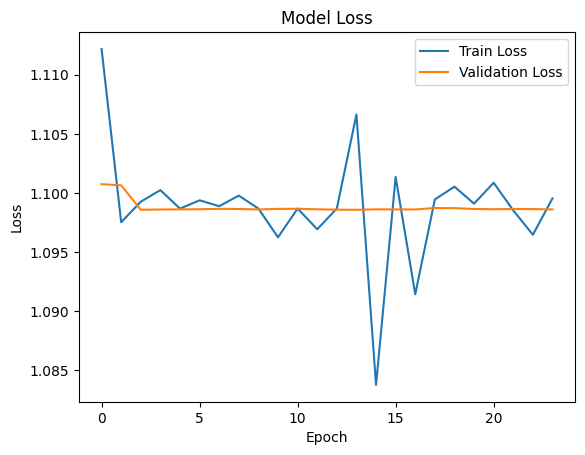

In [ ]:
# Đánh giá trên tập test
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")

# Vẽ biểu đồ Accuracy
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Vẽ biểu đồ Loss
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Lấy dự đoán từ tập test
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# In số lượng dự đoán cho mỗi class
from collections import Counter
print("Predicted class distribution:", Counter(predicted_classes))
print("True class distribution:", Counter(true_classes))

# In vài dự đoán mẫu
print("Sample predictions (probabilities):", predictions[:5])
print("Sample predicted classes:", predicted_classes[:5])
print("Sample true classes:", true_classes[:5])

17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 529ms/step
Predicted class distribution: Counter({0: 540})
True class distribution: Counter({0: 180, 1: 180, 2: 180})
Sample predictions (probabilities): [[0.33466166 0.33373085 0.33160746]
 [0.33466166 0.33373085 0.33160746]
 [0.33466166 0.33373085 0.33160746]
 [0.33466166 0.33373085 0.33160746]
 [0.33466166 0.33373085 0.33160746]]
Sample predicted classes: [0 0 0 0 0]
Sample true classes: [0 0 0 0 0]


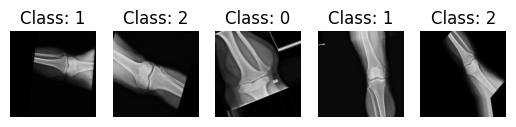

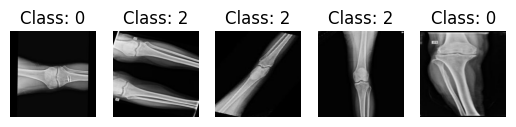

In [ ]:
import matplotlib.pyplot as plt

# Lấy một batch từ train_generator
images, labels = next(train_generator)

# Hiển thị 5 ảnh đầu tiên từ batch
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Class: {np.argmax(labels[i])}")
    plt.axis('off')
plt.show()

# Kiểm tra batch tiếp theo từ valid_generator
images_val, labels_val = next(valid_generator)
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images_val[i])
    plt.title(f"Class: {np.argmax(labels_val[i])}")
    plt.axis('off')
plt.show()

In [ ]:
from collections import Counter
import numpy as np

# Kiểm tra số lượng mẫu mỗi class
print("Train class distribution:", Counter(train_generator.classes))
print("Valid class distribution:", Counter(valid_generator.classes))
print("Test class distribution:", Counter(test_generator.classes))

# Kiểm tra một batch dữ liệu
images, labels = next(train_generator)
print("Image shape:", images.shape)  # Kiểm tra xem có phải (32, 224, 224, 3) không
print("Label shape:", labels.shape)  # Kiểm tra xem có phải (32, 3) không
print("Sample image min/max:", images[0].min(), images[0].max())  # Kiểm tra giá trị pixel

Train class distribution: Counter({0: 1260, 1: 1260, 2: 1260})
Valid class distribution: Counter({0: 360, 1: 360, 2: 360})
Test class distribution: Counter({0: 180, 1: 180, 2: 180})
Image shape: (16, 224, 224, 3)
Label shape: (16, 3)
Sample image min/max: 0.0 0.9579928
